딥러닝 기초 스터디 / 박찬영

# 📌 10.2. 트랜스포머 어텐션

☑️ **10.2.1. seq2seq**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/MyDrive/2025-1 프로메테우스 스터디")

Mounted at /content/drive


In [ ]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import os
import re
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import re
com = re.compile('[cats]')
com.findall('I love cats.')

['c', 'a', 't', 's']

In [ ]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20

class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):  # 문장을 단어 단위로 분리, 컨테이너(word)에 추가
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def normalizeString(df, lang):
    sentence = df[lang].str.lower()  # 소문자
    sentence = sentence.str.replace('[^A-Za-z\s]+', ' ')  # a-z, A-Z, …, ?, ! 등을 제외하고 모두 공백으로 바꿈
    sentence = sentence.str.normalize('NFD')  # 유니코드 정규화 방식
    sentence = sentence.str.encode('ascii', errors='ignore').str.decode('utf-8')  # Unicode를 ASCII로 전환
    return sentence

def read_sentence(df, lang1, lang2):
    sentence1 = normalizeString(df, lang1)  # 첫 번째 열(영어)
    sentence2 = normalizeString(df, lang2)  # 두 번째 열(프랑스어)
    return sentence1, sentence2

def read_file(loc, lang1, lang2):
    df = pd.read_csv(loc, delimiter='\t', header=None, names=[lang1, lang2])
    return df

def process_data(lang1,lang2):  # 데이터셋 불러오기
    df = read_file('chap10/data/%s-%s.txt' % (lang1, lang2), lang1, lang2)
    sentence1, sentence2 = read_sentence(df, lang1, lang2)

    input_lang = Lang()
    output_lang = Lang()
    pairs = []
    for i in range(len(df)):
        if len(sentence1[i].split(' ')) < MAX_LENGTH and len(sentence2[i].split(' ')) < MAX_LENGTH:
            full = [sentence1[i], sentence2[i]]  # 첫 번째와 두 번째 열을 합쳐서 저장
            input_lang.addSentence(sentence1[i])  # 입력(input)으로 영어를 사용
            output_lang.addSentence(sentence2[i])  # 출력(output)으로 프랑스어를 사용
            pairs.append(full)  # pairs에는 입력과 출력이 합쳐진 것을 사용

    return input_lang, output_lang, pairs

In [ ]:
def indexesFromSentence(lang, sentence):  # 문장을 단어로 분리하고 인덱스를 반환
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):  # 딕셔너리에서 단어에 대한 인덱스를 가져오고 문장 끝에 토큰을 추가
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(input_lang, output_lang, pair):  # 입력과 출력 문장을 텐서로 변환하여 반환
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return(input_tensor, target_tensor)

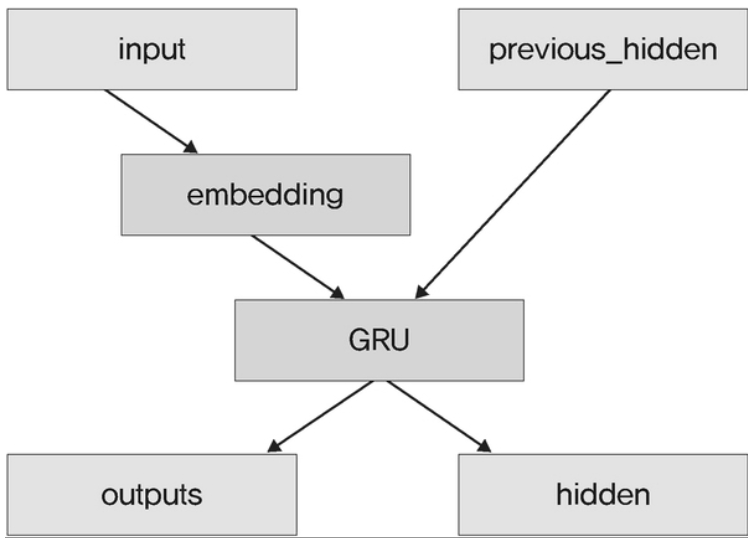

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embbed_dim, num_layers):
        super(Encoder, self).__init__()
        self.input_dim = input_dim  # 입력층
        self.embbed_dim = embbed_dim  # 임베딩 계층
        self.hidden_dim = hidden_dim  # 은닉층(이전 은닉층)
        self.num_layers = num_layers  # GRU의 계층 개수
        self.embedding = nn.Embedding(input_dim, self.embbed_dim)
        # embbed_dim -> hidden_dim
        self.gru = nn.GRU(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)

    def forward(self, src):
        embedded = self.embedding(src).view(1, 1, -1)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

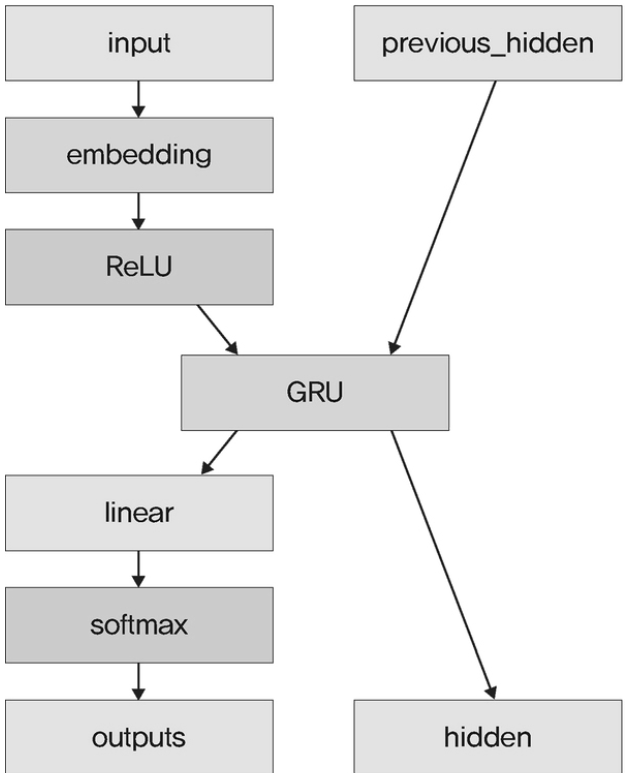

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, embbed_dim, num_layers):
        super(Decoder, self).__init__()
        self.embbed_dim = embbed_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_dim, self.embbed_dim)
        # embbed_dim -> hidden_dim
        self.gru = nn.GRU(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)
        # hidden_dim -> output_dim
        self.out = nn.Linear(self.hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = input.view(1, -1)  # 입력을 (1, 배치 크기)로 변경
        embedded = F.relu(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        prediction = self.softmax(self.out(output[0]))
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, MAX_LENGTH=MAX_LENGTH):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, input_lang, output_lang, teacher_forcing_ratio=0.5):
        input_length = input_lang.size(0)  # 입력 문자 길이(문장의 단어 수)
        batch_size = output_lang.shape[1]
        target_length = output_lang.shape[0]
        vocab_size = self.decoder.output_dim
        outputs = torch.zeros(target_length, batch_size, vocab_size).to(self.device)  # 예측된 출력을 저장하기 위한 변수

        for i in range(input_length):
            encoder_output, encoder_hidden = self.encoder(input_lang[i])  # 문장의 모든 단어를 인코딩
        decoder_hidden = encoder_hidden.to(device)  # 인코더의 은닉층을 디코더의 은닉층으로 사용
        decoder_input = torch.tensor([SOS_token], device=device)  # 첫 번째 예측 단어 앞에 토큰(SOS) 추가

        for t in range(target_length):  # 현재 단어에서 출력 단어를 예측
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio  # teacher force : 번역(예측)하려는 목표 단어를 디코더의 다음 입력으로 넣어줌
            topv, topi = decoder_output.topk(1)
            input = (output_lang[t] if teacher_force else topi)  # teacher_force -> 목표 단어를 다음 입력으로 사용
            if (teacher_force == False and input.item() == EOS_token):  # teacher_force X -> 자체 예측 값을 다음 입력으로 사용
                break
        return outputs

In [ ]:
teacher_forcing_ratio = 0.5

def Model(model, input_tensor, target_tensor, model_optimizer,  criterion):
    model_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    loss = 0
    epoch_loss = 0
    output = model(input_tensor, target_tensor)
    num_iter = output.size(0)

    for ot in range(num_iter):
        loss += criterion(output[ot], target_tensor[ot])
    loss.backward()
    model_optimizer.step()
    epoch_loss = loss.item() / num_iter
    return epoch_loss

In [ ]:
def trainModel(model, input_lang, output_lang, pairs, num_iteration=20000):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()  # 분류 문제 (소프트맥스 사용할 것임을 명시해야 함)
    total_loss_iterations = 0

    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs)) for i in range(num_iteration)]

    for iter in range(1, num_iteration+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = Model(model, input_tensor, target_tensor, optimizer, criterion)
        total_loss_iterations += loss

        if iter % 5000 == 0:
            average_loss= total_loss_iterations / 5000
            total_loss_iterations = 0
            print('%d %.4f' % (iter, average_loss))

    torch.save(model.state_dict(), 'chap10/data/mytraining.pt')
    return model

In [ ]:
def evaluate(model, input_lang, output_lang, sentences, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentences[0])
        output_tensor = tensorFromSentence(output_lang, sentences[1])
        decoded_words = []
        output = model(input_tensor, output_tensor)

        for ot in range(output.size(0)):
            topv, topi = output[ot].topk(1)  # 각 출력에서 가장 높은 값을 찾아 인덱스를 반환

            if topi[0].item() == EOS_token:
                decoded_words.append('<EOS>')  # EOS 토큰을 만나면 평가를 멈춤
                break
            else:
                decoded_words.append(output_lang.index2word[topi[0].item()])  # 예측 결과를 출력 문자열에 추가

    return decoded_words

def evaluateRandomly(model, input_lang, output_lang, pairs, n=10): # 훈련 데이터셋으로부터 임의의 문장을 가져와서 모델 평가
    for i in range(n):
        pair = random.choice(pairs)  # 임의로 문장을 가져옴
        print('input {}'.format(pair[0]))
        print('output {}'.format(pair[1]))
        output_words = evaluate(model, input_lang, output_lang, pair)  # 모델 평가 결과
        output_sentence = ' '.join(output_words)
        print('predicted {}'.format(output_sentence))

In [ ]:
lang1 = 'eng'
lang2 = 'fra'
input_lang, output_lang, pairs = process_data(lang1, lang2)

randomize = random.choice(pairs)
print('random sentence {}'.format(randomize))

input_size = input_lang.n_words
output_size = output_lang.n_words
print('Input : {} Output : {}'.format(input_size, output_size))

embed_size = 256
hidden_size = 512
num_layers = 1
num_iteration = 75000

# 인코더에 훈련 데이터셋을 입력하고 모든 출력과 은닉 상태를 저장
encoder = Encoder(input_size, hidden_size, embed_size, num_layers)
# 디코더의 첫 번째 입력으로 <SOS> 토큰이 제공
# 인코더의 마지막 은닉 상태가 디코더의 첫 번째 은닉 상태로 제공
decoder = Decoder(output_size, hidden_size, embed_size, num_layers)
model = Seq2Seq(encoder, decoder, device).to(device)

print(encoder)
print(decoder)

model = trainModel(model, input_lang, output_lang, pairs, num_iteration)

random sentence ['we had so much fun together.', 'nous nous sommes tellement amuses ensemble.']
Input : 23191 Output : 39387
Encoder(
  (embedding): Embedding(23191, 256)
  (gru): GRU(256, 512)
)
Decoder(
  (embedding): Embedding(39387, 256)
  (gru): GRU(256, 512)
  (out): Linear(in_features=512, out_features=39387, bias=True)
  (softmax): LogSoftmax(dim=1)
)
5000 4.9869
10000 4.7831
15000 4.7384
20000 4.6824
25000 4.6736
30000 4.6555
35000 4.6212
40000 4.6138
45000 4.5968
50000 4.5940
55000 4.5742
60000 4.5489
65000 4.5406
70000 4.5802
75000 4.5436


In [ ]:
evaluateRandomly(model, input_lang, output_lang, pairs)

input you'll have to ask tom that.
output tu devras demander cela a tom.
predicted je ne que pas <EOS>
input his wish was to go to america.
output son souhait etait d'aller aux etats-unis d'amerique.
predicted je ne que pas <EOS>
input tom doesn't need to know where i'm going.
output tom n'a pas besoin de savoir ou je vais.
predicted je ne que pas <EOS>
input we have nothing to lose and everything to gain.
output nous n'avons rien a perdre et tout a gagner.
predicted je ne que pas <EOS>
input you have brought shame upon our family.
output tu as couvert notre famille de honte.
predicted je ne que pas <EOS>
input do as you like.
output fais comme tu veux.
predicted je ne que pas <EOS>
input if he doesn't come, what will you do then?
output s'il ne vient pas, que feras-tu alors?
predicted je ne que pas <EOS>
input you're a traitor.
output vous etes un traitre.
predicted je ne que pas <EOS>
input i think tom really is a doctor.
output je pense que tom est vraiment medecin.
predicted je ne 

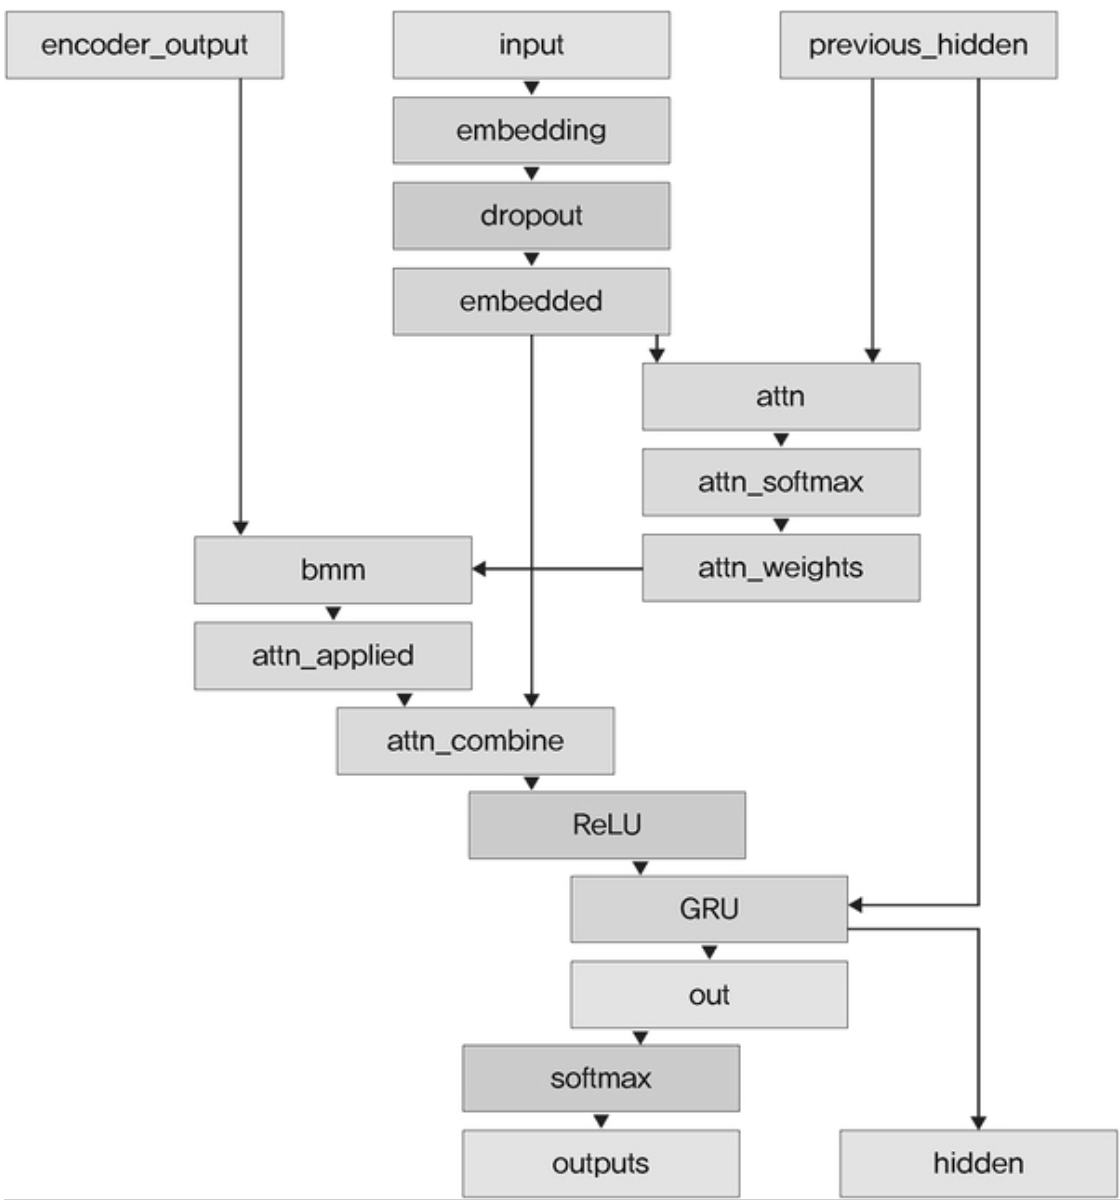

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # vocab_size -> hidden_dim
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # hidden_dim (embedding vector) + hidden_dim (hidden state) -> hidden_dim
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)  # 입력을 디코더로 변환
        # hidden_dim (embedding vector) + hidden_dim (attention applied encoder output) -> hidden_dim
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        # hidden_dim -> vocab_size
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # torch.bmm : 배치 행렬 곱 (BN, A, B) x (BN, B, C) -> (BN, A, C)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]  # 입력+출력 쌍에서 입력을 input_tensor로 사용
        target_tensor = training_pair[1]  # 입력+출력 쌍에서 출력을 target_tensor로 사용
        loss = Model(model, input_tensor, target_tensor, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % 5000 == 0:
            print_loss_avg = print_loss_total / 5000
            print_loss_total = 0
            print('%d, %.4f' % (iter, print_loss_avg))

In [ ]:
import time

embed_size = 256
hidden_size = 512
num_layers = 1
input_size = input_lang.n_words
output_size = output_lang.n_words

encoder1 = Encoder(input_size, hidden_size, embed_size, num_layers)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_size, dropout_p=0.1).to(device)
print(encoder1)
print(attn_decoder1)

attn_model = trainIters(encoder1, attn_decoder1, 75000, print_every=5000, plot_every=100, learning_rate=0.01)

Encoder(
  (embedding): Embedding(23191, 256)
  (gru): GRU(256, 512)
)
AttnDecoderRNN(
  (embedding): Embedding(39387, 512)
  (attn): Linear(in_features=1024, out_features=20, bias=True)
  (attn_combine): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(512, 512)
  (out): Linear(in_features=512, out_features=39387, bias=True)
)
5000, 4.9642
10000, 4.9947
15000, 4.9386
20000, 4.9324
25000, 4.9278
30000, 4.9089
35000, 4.9091
40000, 4.9110
45000, 4.9632
50000, 4.9497
55000, 4.9466
60000, 4.9485
65000, 4.9487
70000, 4.9792
75000, 4.9344


☑️ **10.2.2. 버트(BERT)**

In [ ]:
!pip install transformers
!pip install pytorch-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_df = pd.read_csv('chap10/data/training.txt', sep='\t')
valid_df = pd.read_csv('chap10/data/validing.txt', sep='\t')
test_df = pd.read_csv('chap10/data/testing.txt', sep='\t')

train_df = train_df.sample(frac=0.1, random_state=500)
valid_df = valid_df.sample(frac=0.1, random_state=500)
test_df = test_df.sample(frac=0.1, random_state=500)

In [ ]:
class Datasets(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 2]
        return text, label

In [ ]:
train_dataset = Datasets(train_df)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

valid_dataset = Datasets(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = Datasets(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

100%|██████████| 440473133/440473133 [00:12<00:00, 36689332.90B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(), 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model,
    optimizer,
    criterion=nn.BCELoss(),  # 이진 분류 -> BinaryCrossEntropy(BCELoss)
    num_epochs=5,
    eval_every=len(train_loader)//2,
    best_valid_loss=float("Inf")):

  total_correct = 0.0
  total_len = 0.0
  running_loss = 0.0
  valid_running_loss = 0.0
  global_step = 0
  train_loss_list = []
  valid_loss_list = []
  global_steps_list = []

  model.train()
  for epoch in range(num_epochs):
      for text, label in train_loader:
          optimizer.zero_grad()
          encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
          padded_list = [e + [0] * (512-len(e)) for e in encoded_list]  # 인코딩 결과에 제로패딩(zero-padding)을 적용
          sample = torch.tensor(padded_list)
          sample, label = sample.to(device), label.to(device)
          labels = torch.tensor(label)
          outputs = model(sample, labels=labels)
          loss, logits = outputs

          pred = torch.argmax(F.softmax(logits), dim=1)
          correct = pred.eq(labels)
          total_correct += correct.sum().item()
          total_len += len(labels)
          running_loss += loss.item()
          loss.backward()
          optimizer.step()
          global_step += 1

          if global_step % eval_every == 0:  # 모델 평가
              model.eval()
              with torch.no_grad():
                  for text, label in valid_loader:
                      encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
                      padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
                      sample = torch.tensor(padded_list)
                      sample, label = sample.to(device), label.to(device)
                      labels = torch.tensor(label)
                      outputs = model(sample, labels=labels)
                      loss, logits = outputs
                      valid_running_loss += loss.item()

              average_train_loss = running_loss / eval_every
              average_valid_loss = valid_running_loss / len(valid_loader)
              train_loss_list.append(average_train_loss)
              valid_loss_list.append(average_valid_loss)
              global_steps_list.append(global_step)

              running_loss = 0.0
              valid_running_loss = 0.0
              model.train()

              print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
  .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader), average_train_loss, average_valid_loss))

              if best_valid_loss > average_valid_loss:  # 가장 낮은 오차를 갖는 모델에서 학습 마치기
                  best_valid_loss = average_valid_loss
                  save_checkpoint('chap10/data/model.pt', model, best_valid_loss)
                  save_metrics('chap10/data/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

      save_metrics('chap10/data/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
      print('훈련 종료!')

<ipython-input-30-076edd5be68c>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
<ipython-input-30-076edd5be68c>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
<ipython-input-30-076edd5be68c>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Epoch [1/5], Step [510/5100], Train Loss: 0.7145, Valid Loss: 0.7083
Model saved to ==> chap10/data/model.pt
Model saved to ==> chap10/data/metrics.pt
Epoch [1/5], Step [1020/5100], Train Loss: 0.7045, Valid Loss: 0.7121
Model saved to ==> chap10/data/metrics.pt
훈련 종료!
Epoch [2/5], Step [1530/5100], Train Loss: 0.7127, Valid Loss: 0.6927
Model saved to ==> chap10/data/model.pt
Model saved to ==> chap10/data/metrics.pt
Epoch [2/5], Step [2040/5100], Train Loss: 0.7083, Valid Loss: 0.6995
Model saved to ==> chap10/data/metrics.pt
훈련 종료!
Epoch [3/5], Step [2550/5100], Train Loss: 0.7043, Valid Loss: 0.7058
Epoch [3/5], Step [3060/5100], Train Loss: 0.6975, Valid Loss: 0.7082
Model saved to ==> chap10/data/metrics.pt
훈련 종료!
Epoch [4/5], Step [3570/5100], Train Loss: 0.6992, Valid Loss: 0.6926
Model saved to ==> chap10/data/model.pt
Model saved to ==> chap10/data/metrics.pt
Epoch [4/5], Step [4080/5100], Train Loss: 0.6998, Valid Loss: 0.6933
Model saved to ==> chap10/data/metrics.pt
훈련 종료!

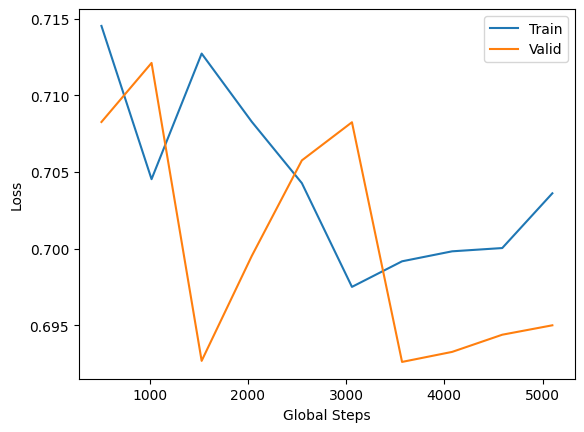

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer)

train_loss_list, valid_loss_list, global_steps_list = load_metrics('chap10/data/metrics.pt')

plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for text, label in test_loader:
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            output = model(sample, labels=labels)
            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    print('Classification 결과:')
    # 정밀도, 재현율, F1-스코어를 구하기 위해 classification_report를 제공
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])  # 레이블, 예측값, 출력에 대한 순서
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")  # 데이터셋, 각 셀에 숫자 입력, 플롯 축, 색상, 숫자의 형태(정수)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])

Model loaded from <== chap10/data/model.pt


<ipython-input-32-e0089aebf974>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Classification 결과:
              precision    recall  f1-score   support

           1     0.5091    1.0000    0.6747       558
           0     0.0000    0.0000    0.0000       538

    accuracy                         0.5091      1096
   macro avg     0.2546    0.5000    0.3374      1096
weighted avg     0.2592    0.5091    0.3435      1096



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


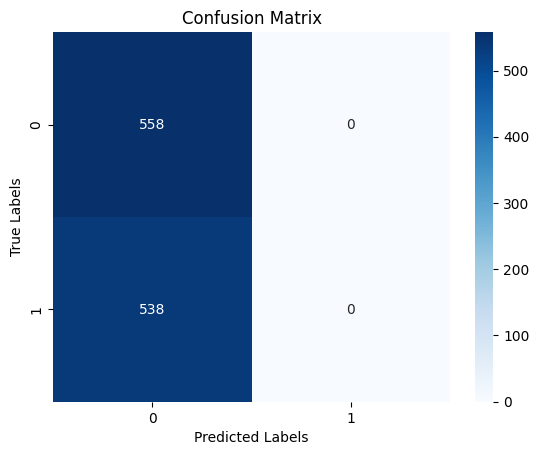

In [ ]:
best_model = model.to(device)
load_checkpoint('chap10/data/model.pt', best_model)
evaluate(best_model, test_loader)

--

# 📌 10.3. 한국어 임베딩

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
text = "나는 파이토치를 이용한 딥러닝을 학습중이다."
marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)  # 단어의 가장 작은 조각을 기준으로 쪼개기

['[CLS]', '나는', '파', '##이', '##토', '##치를', '이', '##용한', '딥', '##러', '##닝', '##을', '학', '##습', '##중', '##이다', '.', '[SEP]']


In [ ]:
text = "과수원에 사과가 많았다." \
       "친구가 나에게 사과했다." \
       "백설공주는 독이 든 사과를 먹었다."
marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)  # 토큰으로 분리
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)  # 인덱스 매핑
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
과             8,898
##수          15,891
##원에         108,280
사             9,405
##과          11,882
##가          11,287
많             9,249
##았다         27,303
.               119
친             9,781
##구          17,196
##가          11,287
나             8,982
##에게         26,212
사             9,405
##과          11,882
##했다         12,490
.               119
백             9,331
##설          31,928
##공          28,000
##주는         100,633
독             9,088
##이          10,739
든             9,115
사             9,405
##과          11,882
##를          11,513
먹             9,266
##었다         17,706
.               119
[SEP]           102


In [ ]:
segments_ids = [1] * len(tokenized_text)  # 문장 구별하기 위해 1과 0 사용
print(segments_ids)

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
model = BertModel.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True)  # 은닉 상태의 값 가져오기
model.eval()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]  # 네트워크의 은닉 상태

print("계층 개수:", len(hidden_states), " (initial embeddings + 12 BERT layers)")
layer_i = 0
print("배치 개수:", len(hidden_states[layer_i]))
batch_i = 0
print("토큰 개수:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print("은닉층의 유닛 개수:", len(hidden_states[layer_i][batch_i][token_i]))

print('은닉 상태의 유형: ', type(hidden_states))
print('각 계층에서의 텐서 형태: ', hidden_states[0].size())

계층 개수: 13  (initial embeddings + 12 BERT layers)
배치 개수: 1
토큰 개수: 33
은닉층의 유닛 개수: 768
은닉 상태의 유형:  <class 'tuple'>
각 계층에서의 텐서 형태:  torch.Size([1, 33, 768])


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)  #  각 계층의 텐서 결합은 stack을 사용
token_embeddings.size()

token_embeddings = torch.squeeze(token_embeddings, dim=1)  # 배치 차원(1) 제거
token_embeddings.size()

token_embeddings = token_embeddings.permute(1, 0, 2) # 계층 개수, 토큰 개수 차원 위치 바꾸기
token_embeddings.size()

torch.Size([33, 13, 768])

In [ ]:
token_vecs_cat = []  # 형태가 [33×(33×768)]인 벡터를 [33×25,344]로 변경하여 저장
for token in token_embeddings:  # token_embeddings : [33×12×768] 형태
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    token_vecs_cat.append(cat_vec)  # 개별 토큰 [12×768], 4개 계층 이어 붙이면 길이 3072
print('형태는: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))  # 33×3072

token_vecs_sum = []  # [33×768] 형태의 토큰을 벡터로 저장
for token in token_embeddings:  # token_embeddings : [33×12×768] 형태
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)
print('형태는: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))  # 33×768

형태는: 33 x 3072
형태는: 33 x 768


In [ ]:
token_vecs = hidden_states[-2][0] # 은닉 상태의 형태 [13×1×33×768]
sentence_embedding = torch.mean(token_vecs, dim=0)
print("최종 임베딩 벡터의 형태:", sentence_embedding.size())  # 768

최종 임베딩 벡터의 형태: torch.Size([768])


In [ ]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 과
2 ##수
3 ##원에
4 사
5 ##과
6 ##가
7 많
8 ##았다
9 .
10 친
11 ##구
12 ##가
13 나
14 ##에게
15 사
16 ##과
17 ##했다
18 .
19 백
20 ##설
21 ##공
22 ##주는
23 독
24 ##이
25 든
26 사
27 ##과
28 ##를
29 먹
30 ##었다
31 .
32 [SEP]


In [ ]:
print("사과가 많았다", str(token_vecs_sum[6][:5]))
print("나에게 사과했다", str(token_vecs_sum[10][:5]))
print("사과를 먹었다", str(token_vecs_sum[19][:5]))

사과가 많았다 tensor([-0.5844, -4.0836,  0.4906,  0.8915, -1.8054])
나에게 사과했다 tensor([-0.8631, -3.4047, -0.7351,  0.9805, -2.6700])
사과를 먹었다 tensor([ 0.6756, -0.3618,  0.0586,  2.2050, -2.4193])


In [ ]:
from scipy.spatial.distance import cosine
# '사과가 많았다' - '나에게 사과했다' / '시과를 먹었다' 에서 '사과' 사이의 코사인 유사도
diff_apple = 1 - cosine(token_vecs_sum[5], token_vecs_sum[27])
same_apple = 1 - cosine(token_vecs_sum[5], token_vecs_sum[16])
print('*유사한* 의미에 대한 벡터 유사성: %.2f' % same_apple)
print('*다른* 의미에 대한 벡터 유사성: %.2f' % diff_apple)

*유사한* 의미에 대한 벡터 유사성: 0.86
*다른* 의미에 대한 벡터 유사성: 0.91
